In [1]:
import gymnasium as gym
import torch
import random
import matplotlib
import matplotlib.pyplot as plt
import math

In [2]:
from collections import namedtuple, deque
from itertools import count

#### Matplotlib Setup

In [3]:
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

#### Check if GPU is available

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

#### Definition of the Replay Memory

In [5]:
Transition = namedtuple("Transition", ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):

    def __init__(self, capacity: int = 2500):
        self.memory = deque([], maxlen=capacity)
    def push(self, *args):
        """
        Save the Transition Object to the Memory
        """
        self.memory.append(Transition(*args))

    def sample(self, batch_size: int):
        return  random.sample(self.memory, batch_size)
    
    def __len__(self) -> int:
        return len(self.memory)

In [6]:
class DQN(torch.nn.Module):
    """
    Model used in the Gymnasium Enviroment
    """

    def __init__(self, num_observations: int, num_actions: int):
        super(DQN, self).__init__()
        self.layer1 = torch.nn.Linear(num_observations, 128)
        self.layer2 = torch.nn.Linear(128, 128)
        self.layer3 = torch.nn.Linear(128, num_actions)

    def forward(self,x):
        x = torch.nn.functional.relu(self.layer1(x))
        x = torch.nn.functional.relu(self.layer2(x))
        return self.layer3(x)

#### Hyperparameter Tuning

In [7]:
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005
LR = 1e-4
ENV = gym.make('Acrobot-v1')

In [8]:
num_actions = ENV.action_space.n
num_actions

3

In [9]:
state, info = ENV.reset()
num_observations = len(state)
print(f'state: {state}, info: {info}, num_observations: {num_observations}')

state: [ 0.9960111  -0.08922981  0.9990194   0.04427509  0.09650007 -0.04958868], info: {}, num_observations: 6


In [10]:
policy_net = DQN(num_observations, num_actions).to(device=device)
target_net = DQN(num_observations, num_actions).to(device=device)
target_net.load_state_dict(policy_net.state_dict())

<All keys matched successfully>

In [11]:
optimizer = torch.optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)
steps_done = 0

In [12]:
def select_action(state) -> torch.tensor:
    global steps_done
    sample = random.random()
    eps_threhold = EPS_END + (EPS_START -EPS_END) * math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threhold:
        with torch.no_grad():
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[ENV.action_space.sample()]], device=device, dtype=torch.long)

In [13]:
episode_durations = []

def plot_durations(show_result: bool = False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title("Result")
    else:
        plt.clf()
        plt.title("Training")
    plt.xlabel("Episode")
    plt.ylabel("Duration")
    plt.plot(durations_t.numpy())
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())
    
    plt.pause(0.001)
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

In [14]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))

    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool)
    non_final_mask_next_state = torch.cat([s for s in batch.next_state if s is not None])

    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)
    
    state_action_values = policy_net(state_batch).gather(1, action_batch)


    next_state_values = torch.zeros(BATCH_SIZE, device=device)

    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_mask_next_state).max(1)[0]


    expected_state_action_values = (next_state_values * GAMMA) + reward_batch


    criterion = torch.nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    optimizer.zero_grad()
    loss.backward()

    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

In [15]:
if torch.cuda.is_available():
    num_episodes = 2000
else:
    num_episodes = 50

Complete


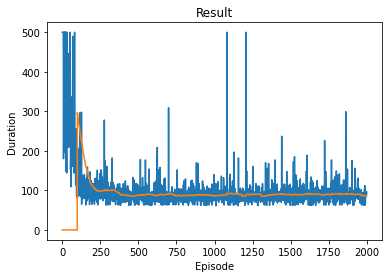

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [16]:
for i_episode in range(num_episodes):
    state, info = ENV.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    for t in count():
        action = select_action(state=state)
        observation, reward, terminated, truncated, _ = ENV.step(action.item())
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        memory.push(state, action, next_state, reward)

        state = next_state
        optimize_model()

        target_net_state_dict= target_net.state_dict()
        policy_net_state_dict= policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            episode_durations.append(t+1)
            plot_durations() 
            break

print('Complete')
plot_durations(show_result=True)
plt.ioff()
plt.show()

In [18]:
torch.save(target_net, "target_net.pt")

In [19]:
torch.save(policy_net, "policy_net.pt")